In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('ggplot')

np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.max_columns', None)
sns.set(font_scale=1.2)

# New Section

In [11]:
import glob
import random 
from tqdm import tqdm

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Input, Dropout, Flatten, Dense, MaxPool2D

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
renders_path = "/content/gdrive/MyDrive/Zeta_Surgical_Project/renders"
render_new_path = "/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new"
render_new_test_path = "/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new_test"
project_path = "/content/gdrive/MyDrive/Zeta_Surgical_Project/"

In [14]:
directories = glob.glob(render_new_path+"/*")
print(directories)

['/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new/subarachnoid', '/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new/epidural', '/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new/intraparenchymal', '/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new/intraventricular', '/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new/subdural', '/content/gdrive/MyDrive/Zeta_Surgical_Project/render_new/multi']


In [15]:
nrows = len(directories)
ncols = 4

count_images = 0
for i, folder in enumerate(directories):
    all_files = glob.glob(folder+'/*')
    subfolder_path = folder.split('/')[-2:]
    hemorrhage_type, window = subfolder_path
    print(f"folder -> {'/'.join(subfolder_path): >40}, {len(all_files):>7} files")
    count_images += len(all_files)
print(f'total number of images: {count_images}')

folder ->                  render_new/subarachnoid,    1000 files
folder ->                      render_new/epidural,    1000 files
folder ->              render_new/intraparenchymal,    1000 files
folder ->              render_new/intraventricular,    1000 files
folder ->                      render_new/subdural,    1000 files
folder ->                         render_new/multi,    1000 files
total number of images: 6000


In [16]:
hemorrhage_dct = {'epidural': 0, 'intraparenchymal': 2, 'intraventricular': 3, 'multi':4, 'subarachnoid': 5, 'subdural': 6}

In [ ]:
# X = np.zeros((df.shape[0], 128, 128))

# i = 0
# for img_path in tqdm(df['filepath'].values):
#     img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
#     img = cv.resize(img, (128, 128))
#     X[i] = img
#     i += 1

100%|██████████| 9600/9600 [1:14:29<00:00,  2.15it/s]


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# y = keras.utils.to_categorical(df['type'].values)
# x_train, x_test, y_train, y_test = train_test_split(X[..., np.newaxis], y, test_size=0.2, stratify=y)


In [ ]:
# x_train = x_train/255.
# x_test = x_test/255.

In [41]:
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        render_new_path,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        render_new_test_path,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 6000 images belonging to 6 classes.
Found 1192 images belonging to 6 classes.


In [35]:
x, y = next(train_generator)

In [37]:
type(x), type(y), x.shape, y.shape

(numpy.ndarray, numpy.ndarray, (32, 150, 150, 3), (32, 6))

In [42]:
model = Sequential([
    Conv2D(8, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(2, 2),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(2, 2),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(2, 2),
    Conv2D(64, 3, activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax'),
])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 32)      

In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-3, patience=5)
history = model.fit(train_generator, epochs=40, steps_per_epoch=6000//batch_size, validation_data=validation_generator, validation_steps=1192//batch_size)

Epoch 1/40
  4/187 [..............................] - ETA: 47:27 - loss: 2.1720 - accuracy: 0.1719

KeyboardInterrupt: ignored

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].legend()
    plt.savefig('loss_accuracy_history.png')

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].legend()
    plt.savefig(project_path+'loss_accuracy_history.png')

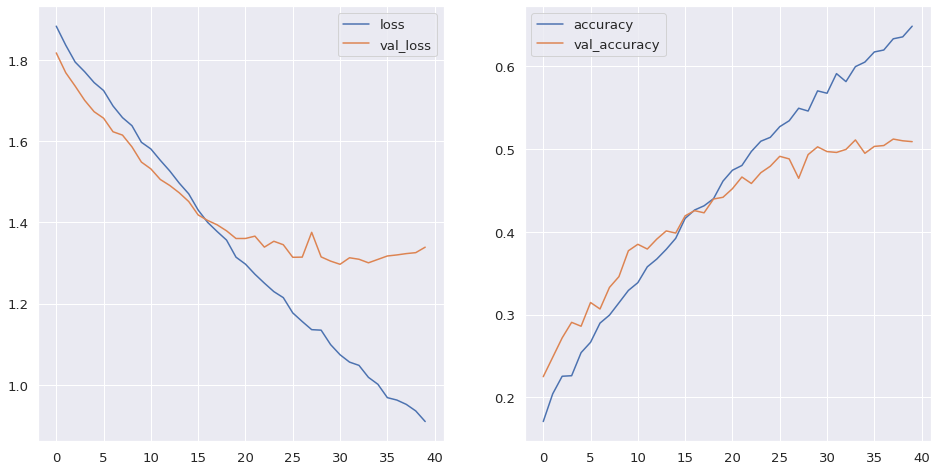

In [ ]:
plot_history(history)

In [ ]:
for dir in directories:
    print(dir)

/content/gdrive/MyDrive/Zeta_Surgical_Project/renders/multi
/content/gdrive/MyDrive/Zeta_Surgical_Project/renders/subdural
/content/gdrive/MyDrive/Zeta_Surgical_Project/renders/epidural
/content/gdrive/MyDrive/Zeta_Surgical_Project/renders/intraparenchymal
/content/gdrive/MyDrive/Zeta_Surgical_Project/renders/intraventricular
/content/gdrive/MyDrive/Zeta_Surgical_Project/renders/subarachnoid


6


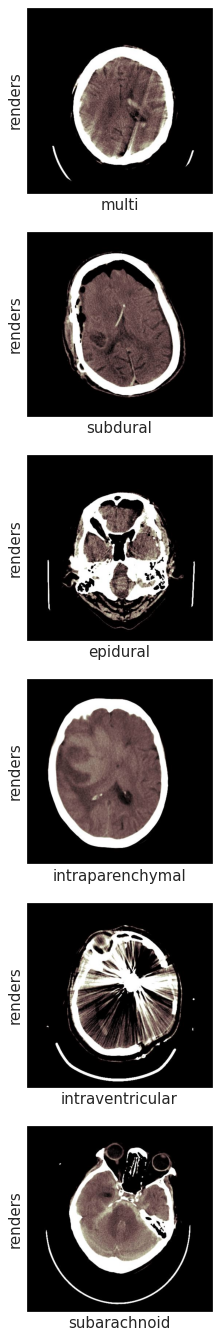

In [ ]:
nrows = 6
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
print(len(directories))
for i, folder in enumerate(directories):
    all_files = glob.glob(folder+'/*')
    subfolder_path = folder.split('/')[-2:]
    hemorrhage_type, window = subfolder_path
#         print(f"folder -> {'/'.join(subfolder_path): >40}, {len(all_files):>7} files")
    img_path = random.choice(all_files)
    img_name = '/'.join(img_path.split('/')[:-2]) + '/' + window + '/' + img_path.split('/')[-1]
    ax[i].imshow(cv.imread(img_name), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if True:
        ax[i].set_ylabel(hemorrhage_type, fontsize=15)
    if True:
        ax[i].set_xlabel(window, fontsize=15)

In [ ]:
print(df.shape)
df.head()

(9600, 2)


,filepath,type
0,/content/gdrive/MyDrive/Zeta_Surgical_Project/...,3
1,/content/gdrive/MyDrive/Zeta_Surgical_Project/...,0
2,/content/gdrive/MyDrive/Zeta_Surgical_Project/...,3
3,/content/gdrive/MyDrive/Zeta_Surgical_Project/...,5
4,/content/gdrive/MyDrive/Zeta_Surgical_Project/...,4


image shape is: (512, 512, 3)


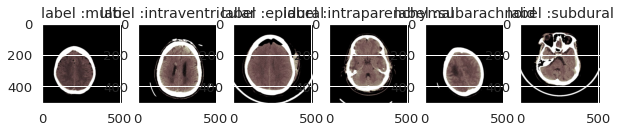

In [ ]:
## randomly select elemest from different labels
unique_labels = df['type'].unique()
fig, ax = plt.subplots(1, len(unique_labels), figsize=(10, 10*len(unique_labels)))
for i, label in enumerate(unique_labels):
    filename =  df[df['type'] == label].sample().iloc[0,0]
    img = cv.imread(filename)
    ax[i].imshow(img)
    ax[i].set_title(f'label :{label}')
print(f'image shape is: {img.shape}')

In [ ]:
renders_path

'/content/gdrive/MyDrive/Zeta_Surgical_Project/renders'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_ds = datagen.flow_from_dataframe(dataframe=df, directory=renders_path, x_col='filepath', y_col='type', 
                                       subset='training', batch_size=64, seed=7, shuffle=True, color_mode='grayscale',
                                       class_mode='categorical', target_size=(128, 128))
val_ds = datagen.flow_from_dataframe(dataframe=df, directory=renders_path, x_col='filepath', y_col='type', 
                                       subset='validation', batch_size=64, seed=7, shuffle=True, color_mode='grayscale',
                                       class_mode='categorical', target_size=(128, 128))

Found 7680 validated image filenames belonging to 6 classes.
Found 1920 validated image filenames belonging to 6 classes.


In [ ]:
model = Sequential([
    Conv2D(8, 3, activation='relu', input_shape=x_train.shape[1:]),
    MaxPool2D(2, 2),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(2, 2),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(2, 2),
    Conv2D(64, 3, activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 8)       80        
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 63, 63, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)      

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(Conv2D(40, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(56, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 508, 508, 40)      11560     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 254, 254, 40)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 252, 252, 48)      17328     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 48)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 124, 124, 56)     

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
STEP_SIZE_TRAIN = train_ds.n//train_ds.batch_size
STEP_SIZE_VAL = val_ds.n//val_ds.batch_size

# early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-3, patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./hemorrhage.h5', verbose=2, save_best_only=True)

history = model.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_ds, validation_steps=STEP_SIZE_VAL, epochs=7, callbacks=[checkpoint])

Epoch 1/7
  5/120 [>.............................] - ETA: 51:43 - loss: 1.8478 - accuracy: 0.1469

KeyboardInterrupt: ignored

In [ ]:
def plot_loss_acc(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].legend()
    ax[0].set_title('Training and Validation Loss')
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].legend()
    ax[1].set_title('Training and Validation Accuracy')
    print('Plots for Loss and Accuracy of training:')
    
plot_loss_acc(history)

### Using a pre-trained Network

In [ ]:
n_classes = 6

base_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_ds, validation_steps=STEP_SIZE_VAL, epochs=5)

Epoch 1/5
300/300 [==============================] - 769s 2s/step - loss: 2.3864 - accuracy: 0.1538 - val_loss: 1.7919 - val_accuracy: 0.1592
Epoch 2/5
300/300 [==============================] - 713s 2s/step - loss: 1.7920 - accuracy: 0.1594 - val_loss: 1.7920 - val_accuracy: 0.1592
Epoch 3/5
300/300 [==============================] - 717s 2s/step - loss: 1.7919 - accuracy: 0.1637 - val_loss: 1.7922 - val_accuracy: 0.1592
Epoch 4/5
 15/300 [>.............................] - ETA: 10:24 - loss: 1.7915 - accuracy: 0.1792

KeyboardInterrupt: ignored

In [ ]:
plot_loss_acc(history=history)